In [2]:
from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("/home/yinglong/Documents/kinodynamic/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("/home/yinglong/Documents/kinodynamic/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
lib2 = CDLL("deps/sparse_rrt/sparse_rrt/_sst_module.so")


In [3]:
from sparse_rrt.planners import SST
from env.cartpole_obs import CartPoleObs
from env.cartpole import CartPole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd

#obs_list = np.array(obs_list)
system = standard_cpp_systems.CartPole()

#bvp_solver = _sst_module.BVPWrapper(system, 4, 1, 24, 0.002)

In [ ]:

#obs_list = np.array(obs_list)
system = standard_cpp_systems.CartPole()
#system = CartPoleObs(obs_list)
# Create SST planner
min_time_steps = 10
max_time_steps = 200
integration_step = 0.002
max_iter = 100000
goal_radius=1.5
random_seed=0
sst_delta_near=2.0
sst_delta_drain=1.2

low = []
high = []
state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
    
start = np.random.uniform(low=low, high=high)
end = np.random.uniform(low=low, high=high)


start[1] = 0.
start[3] = 0.
end[1] = 0.
end[3] = 0.
planner = SST(
    state_bounds=system.get_state_bounds(),
    control_bounds=system.get_control_bounds(),
    distance=system.distance_computer(),
    start_state=start,
    goal_state=end,
    goal_radius=goal_radius,
    random_seed=0,
    sst_delta_near=sst_delta_near,
    sst_delta_drain=sst_delta_drain
)

    
# Run planning and print out solution is some statistics every few iterations.
time0 = time.time()
for iteration in range(max_iter):
    #if iteration % 50 == 0:
    #    # from time to time use the goal
    #    sample = end
    #    planner.step_with_sample(system, sample, 20, 200, 0.002)
    #else:
    planner.step(system, min_time_steps, max_time_steps, integration_step)
    #    #sample = np.random.uniform(low=low, high=high)
    #print('iteration: %d' % (iteration))
    # interation: 0.002
    #planner.step_with_sample(system, sample, 2, 20, 0.01)
    
    #if iteration % 100 == 0:
solution = planner.get_solution()
print("Solution: %s, Number of nodes: %s" % (planner.get_solution(), planner.get_number_of_nodes()))

print('time spent: %f' % (time.time() - time0))
assert solution is not None

In [ ]:
start = np.array([0., 0., 0., 0.])
goal = np.array([5, 0., np.pi, 0.])
solution = bvp_solver.solve(start, goal, 100)
print(solution)


In [ ]:
status, states, actions, times = solution
print(states.shape)
print(actions.shape)

In [4]:
import pickle
f = open('data/cartpole/0/path_232.pkl', 'rb')
#states = pickle.load(f, encoding='latin1')
#u = pickle._Unpickler(f)
#u.encoding = 'latin1'
states = pickle.load(f)

f = open('data/cartpole/0/control_232.pkl', 'rb')
#u = pickle._Unpickler(f)
#u.encoding = 'latin1'
#actions = pickle.load(f, encoding='latin1')
actions = pickle.load(f)

#actions = pickle.load(f, encoding='latin1')
f = open('data/cartpole/0/cost_232.pkl', 'rb')
#u = pickle._Unpickler(f)
#u.encoding = 'latin1'
times = pickle.load(f)

#times = pickle.load(f, encoding='latin1')


In [9]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['animation.ffmpeg_path'] = '/home/yinglong/anaconda2/pkgs/ffmpeg-4.2-h167e202_0/share/ffmpeg'

import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer


class CartPoleVisualizer(Visualizer, object):
    def __init__(self, system, params):
        super(CartPoleVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-20, 20)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,params['cart_h']))
        # print location of cart
        return self.recs


 
    def animate(self, states, actions, times, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            action = actions[i]
            sT = states[i+1]
            time = times[i]
            if time < 1e-3:
                continue
            time_passed = 0.
            # propogate until reaching next state
            while True:
                traj.append(s)
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                time_passed += self.params['integration_step']
                if time_passed >= time:
                    break
                if np.linalg.norm(s-sT) == 0.:
                    break
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(1, len(self.states)),
                                      interval=self.dt, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


state: 0, remaining: 31
state: 1, remaining: 30
state: 2, remaining: 29
state: 3, remaining: 28
state: 4, remaining: 27
state: 5, remaining: 26
state: 6, remaining: 25
state: 7, remaining: 24
state: 8, remaining: 23
state: 9, remaining: 22
state: 10, remaining: 21
state: 11, remaining: 20
state: 12, remaining: 19
state: 13, remaining: 18
state: 14, remaining: 17
state: 15, remaining: 16
state: 16, remaining: 15
state: 17, remaining: 14
state: 18, remaining: 13
state: 19, remaining: 12
state: 20, remaining: 11
state: 21, remaining: 10
state: 22, remaining: 9
state: 23, remaining: 8
state: 24, remaining: 7
state: 25, remaining: 6
state: 26, remaining: 5
state: 27, remaining: 4
state: 28, remaining: 3
state: 29, remaining: 2
animating...
9396


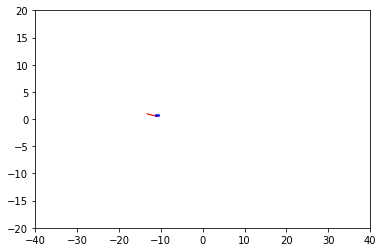

In [10]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.1
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
obs_list = []
system = CartPole(obs_list)
#system = CartPole()
vis = CartPoleVisualizer(system, params)
#status, states, actions, times = solution
anim = vis.animate(states, actions, times, obs_list)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('cartpole.mp4', writer=writer)
#HTML(anim.to_html5_video())


In [ ]:
print(obs_list)